# Phase 1: Data-Driven Time Window Discovery

**Objective**: Analyze temporal patterns to discover optimal time windows for feature extraction, replacing arbitrary choices with data-driven decisions.

**Key Questions**:
- What are the natural time scales in meme coin trading data?
- Which time windows show the strongest autocorrelation patterns?
- How do we move from arbitrary 1/5/10 minute windows to data-driven choices?

**Approach**:
1. **Temporal Resolution Analysis** - Understand actual transaction timing
2. **Natural Time Scale Discovery** - Use autocorrelation and signal-to-noise ratios  
3. **Cross-Coin Validation** - Find universal patterns across multiple coins
4. **Optimal Window Recommendation** - Data-driven window selection

**Expected Outcome**: Replace arbitrary time windows with scientifically determined optimal windows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
%matplotlib inline

# Constants
SOL_MINT = 'So11111111111111111111111111111111111111112'
DATA_PATH = Path('../data/solana/first_day_trades/first_day_trades_batch_578.csv')

print("=== TEMPORAL SIGNAL DEVELOPMENT FRAMEWORK ===")
print("Objective: Extract intraday trading signals from 1/5/10 minute windows")
print("Approach: Systematic feature mining → Signal validation → Cross-coin testing")
print()

# Load data
print("Loading data...")
df = pd.read_csv(DATA_PATH)
df['block_timestamp'] = pd.to_datetime(df['block_timestamp'])

# Recreate coin mapping and trading indicators
unique_mints = df['mint'].unique()
coin_names = {mint: f"Coin_{i}" for i, mint in enumerate(unique_mints, 1)}
df['coin_name'] = df['mint'].map(coin_names)

# Add trading direction and SOL amounts
df['is_buy'] = df['mint'] == df['swap_to_mint']
df['is_sell'] = df['mint'] == df['swap_from_mint']
df['sol_amount'] = 0.0

buy_mask = df['is_buy'] & (df['swap_from_mint'] == SOL_MINT)
sell_mask = df['is_sell'] & (df['swap_to_mint'] == SOL_MINT)
df.loc[buy_mask, 'sol_amount'] = df.loc[buy_mask, 'swap_from_amount']
df.loc[sell_mask, 'sol_amount'] = df.loc[sell_mask, 'swap_to_amount']

# Add transaction sizes for analysis
df['txn_size_category'] = 'Unknown'
df.loc[df['sol_amount'] >= 100, 'txn_size_category'] = 'Whale'
df.loc[(df['sol_amount'] >= 10) & (df['sol_amount'] < 100), 'txn_size_category'] = 'Big'
df.loc[(df['sol_amount'] >= 1) & (df['sol_amount'] < 10), 'txn_size_category'] = 'Medium'
df.loc[(df['sol_amount'] > 0) & (df['sol_amount'] < 1), 'txn_size_category'] = 'Small'

print(f"Data loaded: {len(df):,} transactions across {len(unique_mints)} coins")
print(f"Time range: {df['block_timestamp'].min()} to {df['block_timestamp'].max()}")
print()

# Quick preview of data structure
print("=== DATA STRUCTURE PREVIEW ===")
print(f"Columns: {list(df.columns)}")
print(f"Transaction size distribution:")
print(df['txn_size_category'].value_counts())
print(f"Buy/sell distribution:")
print(f"Buys: {df['is_buy'].sum():,} ({df['is_buy'].mean():.1%})")
print(f"Sells: {df['is_sell'].sum():,} ({df['is_sell'].mean():.1%})")


=== TEMPORAL SIGNAL DEVELOPMENT FRAMEWORK ===
Objective: Extract intraday trading signals from 1/5/10 minute windows
Approach: Systematic feature mining → Signal validation → Cross-coin testing

Loading data...
Data loaded: 1,030,491 transactions across 10 coins
Time range: 2024-03-18 02:16:52+00:00 to 2025-06-11 23:59:59+00:00

=== DATA STRUCTURE PREVIEW ===
Columns: ['mint', 'block_timestamp', 'succeeded', 'swapper', 'swap_from_amount', 'swap_from_mint', 'swap_to_amount', 'swap_to_mint', '__row_index', 'coin_name', 'is_buy', 'is_sell', 'sol_amount', 'txn_size_category']
Transaction size distribution:
txn_size_category
Small     724004
Medium    300713
Big         5629
Whale        145
Name: count, dtype: int64
Buy/sell distribution:
Buys: 537,094 (52.1%)
Sells: 493,397 (47.9%)


In [2]:
def analyze_temporal_resolution(coin_data, coin_name):
    """
    Analyze the actual time resolution and patterns in the data
    """
    
    # Sort by timestamp
    coin_data = coin_data.sort_values('block_timestamp').copy()
    
    # Calculate time differences between consecutive transactions
    coin_data['time_diff_seconds'] = coin_data['block_timestamp'].diff().dt.total_seconds()
    
    # Remove NaN from first row
    time_diffs = coin_data['time_diff_seconds'].dropna()
    
    print(f"=== TEMPORAL ANALYSIS FOR {coin_name} ===")
    print(f"Total transactions: {len(coin_data):,}")
    print(f"Time span: {coin_data['block_timestamp'].max() - coin_data['block_timestamp'].min()}")
    
    # Basic time resolution stats
    print(f"\n--- TIME RESOLUTION ANALYSIS ---")
    print(f"Min time between transactions: {time_diffs.min():.2f} seconds")
    print(f"Max time between transactions: {time_diffs.max():.2f} seconds")
    print(f"Mean time between transactions: {time_diffs.mean():.2f} seconds")
    print(f"Median time between transactions: {time_diffs.median():.2f} seconds")
    print(f"Std time between transactions: {time_diffs.std():.2f} seconds")
    
    # Percentiles
    print(f"\n--- TIME RESOLUTION PERCENTILES ---")
    for pct in [10, 25, 50, 75, 90, 95, 99]:
        print(f"{pct}th percentile: {time_diffs.quantile(pct/100):.2f} seconds")
    
    # Identify common patterns
    print(f"\n--- TRANSACTION FREQUENCY PATTERNS ---")
    very_fast = (time_diffs <= 1).sum()
    fast = ((time_diffs > 1) & (time_diffs <= 5)).sum()
    normal = ((time_diffs > 5) & (time_diffs <= 30)).sum()
    slow = ((time_diffs > 30) & (time_diffs <= 300)).sum()
    very_slow = (time_diffs > 300).sum()
    
    total = len(time_diffs)
    print(f"≤1 second: {very_fast:,} ({very_fast/total:.1%}) - Block-level/Bot trading")
    print(f"1-5 seconds: {fast:,} ({fast/total:.1%}) - High frequency")
    print(f"5-30 seconds: {normal:,} ({normal/total:.1%}) - Normal activity")
    print(f"30-300 seconds: {slow:,} ({slow/total:.1%}) - Low frequency")
    print(f">300 seconds: {very_slow:,} ({very_slow/total:.1%}) - Gaps/Breaks")
    
    return {
        'time_diffs': time_diffs,
        'min_gap': time_diffs.min(),
        'median_gap': time_diffs.median(),
        'mean_gap': time_diffs.mean(),
        'percentiles': {pct: time_diffs.quantile(pct/100) for pct in [10, 25, 50, 75, 90, 95, 99]},
        'frequency_patterns': {
            'very_fast': very_fast / total,
            'fast': fast / total,
            'normal': normal / total,
            'slow': slow / total,
            'very_slow': very_slow / total
        }
    }

def find_natural_time_scales(coin_data, coin_name):
    """
    Find natural time scales in the data using autocorrelation and clustering
    """
    
    coin_data = coin_data.sort_values('block_timestamp').copy()
    
    print(f"\n=== NATURAL TIME SCALE DISCOVERY FOR {coin_name} ===")
    
    # Create time series at different granularities
    granularities = [
        ('5sec', '5S'),
        ('10sec', '10S'), 
        ('30sec', '30S'),
        ('1min', '1min'),
        ('2min', '2min'),
        ('5min', '5min'),
        ('10min', '10min'),
        ('15min', '15min'),
        ('30min', '30min')
    ]
    
    # Set timestamp as index for resampling
    coin_data = coin_data.set_index('block_timestamp')
    
    autocorr_results = {}
    volume_stability = {}
    signal_noise_ratios = {}
    
    for name, freq in granularities:
        # Resample to this frequency
        resampled = coin_data.resample(freq).agg({
            'sol_amount': ['sum', 'count', 'mean'],
            'is_buy': 'mean',
            'swapper': 'nunique'
        })
        
        # Flatten column names
        resampled.columns = ['_'.join(col).strip() for col in resampled.columns]
        resampled = resampled.dropna()
        
        if len(resampled) < 10:  # Skip if too few data points
            continue
            
        # Calculate metrics
        volume_series = resampled['sol_amount_sum'].fillna(0)
        txn_count_series = resampled['sol_amount_count'].fillna(0)
        buy_ratio_series = resampled['is_buy_mean'].fillna(0.5)
        
        # Autocorrelation at lag 1
        if len(volume_series) > 2:
            volume_autocorr = volume_series.autocorr(lag=1)
            txn_autocorr = txn_count_series.autocorr(lag=1)
            buy_autocorr = buy_ratio_series.autocorr(lag=1)
            
            autocorr_results[name] = {
                'volume_autocorr': volume_autocorr,
                'txn_autocorr': txn_autocorr,
                'buy_autocorr': buy_autocorr,
                'avg_autocorr': np.mean([volume_autocorr, txn_autocorr, buy_autocorr])
            }
        
        # Volume stability (inverse of coefficient of variation)
        volume_stability[name] = volume_series.mean() / volume_series.std() if volume_series.std() > 0 else 0
        
        # Signal-to-noise ratio (mean / std)
        signal_noise_ratios[name] = {
            'volume_snr': volume_series.mean() / volume_series.std() if volume_series.std() > 0 else 0,
            'txn_snr': txn_count_series.mean() / txn_count_series.std() if txn_count_series.std() > 0 else 0
        }
    
    # Display results
    print(f"\n--- AUTOCORRELATION ANALYSIS ---")
    print("(Higher values indicate more predictable patterns)")
    for name, results in sorted(autocorr_results.items(), key=lambda x: x[1]['avg_autocorr'], reverse=True):
        print(f"{name:>8}: Volume={results['volume_autocorr']:.3f}, Txn={results['txn_autocorr']:.3f}, Buy={results['buy_autocorr']:.3f}, Avg={results['avg_autocorr']:.3f}")
    
    print(f"\n--- VOLUME STABILITY ANALYSIS ---")
    print("(Higher values indicate more stable/predictable volume)")
    for name, stability in sorted(volume_stability.items(), key=lambda x: x[1], reverse=True):
        print(f"{name:>8}: {stability:.3f}")
    
    print(f"\n--- SIGNAL-TO-NOISE RATIOS ---")
    print("(Higher values indicate cleaner signals)")
    for name, snr in sorted(signal_noise_ratios.items(), key=lambda x: x[1]['volume_snr'], reverse=True):
        print(f"{name:>8}: Volume SNR={snr['volume_snr']:.3f}, Txn SNR={snr['txn_snr']:.3f}")
    
    return {
        'autocorr_results': autocorr_results,
        'volume_stability': volume_stability,
        'signal_noise_ratios': signal_noise_ratios
    }

def recommend_optimal_windows(temporal_analysis, natural_scales):
    """
    Recommend optimal time windows based on analysis
    """
    
    print(f"\n=== OPTIMAL TIME WINDOW RECOMMENDATIONS ===")
    
    # Extract key metrics
    min_gap = temporal_analysis['min_gap']
    median_gap = temporal_analysis['median_gap']
    p75_gap = temporal_analysis['percentiles'][75]
    p90_gap = temporal_analysis['percentiles'][90]
    
    # Recommend windows based on data characteristics
    recommendations = []
    
    # Ultra-short: 2-5x minimum gap
    ultra_short = max(min_gap * 3, 2)  # At least 2 seconds
    recommendations.append(('ultra_short', ultra_short, 'Capture immediate reactions'))
    
    # Short: Around median gap * 10
    short = max(median_gap * 10, 30)  # At least 30 seconds
    recommendations.append(('short', short, 'Capture short-term patterns'))
    
    # Medium: Around 75th percentile * 5
    medium = max(p75_gap * 5, 120)  # At least 2 minutes
    recommendations.append(('medium', medium, 'Capture medium-term trends'))
    
    # Long: Around 90th percentile * 2
    long = max(p90_gap * 2, 300)  # At least 5 minutes
    recommendations.append(('long', long, 'Capture longer-term patterns'))
    
    # Based on autocorrelation results
    if natural_scales['autocorr_results']:
        best_autocorr = max(natural_scales['autocorr_results'].items(), key=lambda x: x[1]['avg_autocorr'])
        print(f"Best autocorrelation found at: {best_autocorr[0]} (avg autocorr: {best_autocorr[1]['avg_autocorr']:.3f})")
        
        # Convert to seconds
        window_map = {
            '5sec': 5, '10sec': 10, '30sec': 30, '1min': 60, '2min': 120,
            '5min': 300, '10min': 600, '15min': 900, '30min': 1800
        }
        if best_autocorr[0] in window_map:
            optimal_seconds = window_map[best_autocorr[0]]
            recommendations.append(('optimal_autocorr', optimal_seconds, f'Best autocorrelation pattern'))
    
    print(f"\n--- RECOMMENDED TIME WINDOWS ---")
    print(f"Based on temporal analysis:")
    for name, seconds, description in recommendations:
        minutes = seconds / 60
        print(f"{name:>16}: {seconds:>6.1f}s ({minutes:>5.1f}min) - {description}")
    
    # Convert to practical windows (remove duplicates and sort)
    practical_windows = []
    for name, seconds, desc in recommendations:
        if seconds not in practical_windows:
            practical_windows.append(seconds)
    
    practical_windows = sorted(practical_windows)
    
    print(f"\n--- FINAL RECOMMENDED WINDOWS ---")
    print(f"Recommended lookback windows (seconds): {practical_windows}")
    print(f"Recommended lookback windows (minutes): {[round(w/60, 1) for w in practical_windows]}")
    
    return practical_windows

# Test the temporal analysis framework
print("=== TEMPORAL RESOLUTION & OPTIMAL WINDOW ANALYSIS ===")
print("Analyzing all coins to find optimal time windows...")

# Analyze each coin
temporal_analyses = {}
natural_scales_analyses = {}

for coin_name in sorted(coin_names.values())[:3]:  # Test first 3 coins
    coin_data = df[df['coin_name'] == coin_name]
    
    if len(coin_data) > 100:  # Only analyze coins with sufficient data
        print(f"\n{'='*80}")
        
        # Temporal resolution analysis
        temporal_analysis = analyze_temporal_resolution(coin_data, coin_name)
        temporal_analyses[coin_name] = temporal_analysis
        
        # Natural time scales analysis
        natural_scales = find_natural_time_scales(coin_data, coin_name)
        natural_scales_analyses[coin_name] = natural_scales
        
        # Recommend optimal windows
        optimal_windows = recommend_optimal_windows(temporal_analysis, natural_scales)
        
        print(f"\n{coin_name} analysis complete!")
        
    else:
        print(f"Skipping {coin_name} - insufficient data ({len(coin_data)} transactions)")


=== TEMPORAL RESOLUTION & OPTIMAL WINDOW ANALYSIS ===
Analyzing all coins to find optimal time windows...

=== TEMPORAL ANALYSIS FOR Coin_1 ===
Total transactions: 61,062
Time span: 0 days 07:14:59

--- TIME RESOLUTION ANALYSIS ---
Min time between transactions: 0.00 seconds
Max time between transactions: 196.00 seconds
Mean time between transactions: 0.43 seconds
Median time between transactions: 0.00 seconds
Std time between transactions: 2.71 seconds

--- TIME RESOLUTION PERCENTILES ---
10th percentile: 0.00 seconds
25th percentile: 0.00 seconds
50th percentile: 0.00 seconds
75th percentile: 0.00 seconds
90th percentile: 0.00 seconds
95th percentile: 2.00 seconds
99th percentile: 11.00 seconds

--- TRANSACTION FREQUENCY PATTERNS ---
≤1 second: 57,813 (94.7%) - Block-level/Bot trading
1-5 seconds: 1,685 (2.8%) - High frequency
5-30 seconds: 1,497 (2.5%) - Normal activity
30-300 seconds: 66 (0.1%) - Low frequency
>300 seconds: 0 (0.0%) - Gaps/Breaks

=== NATURAL TIME SCALE DISCOVERY F


=== CROSS-COIN WINDOW ANALYSIS ===
Finding universal time windows that work across multiple coins

=== OPTIMAL TIME WINDOW RECOMMENDATIONS ===
Best autocorrelation found at: 2min (avg autocorr: 0.615)

--- RECOMMENDED TIME WINDOWS ---
Based on temporal analysis:
     ultra_short:    2.0s (  0.0min) - Capture immediate reactions
           short:   30.0s (  0.5min) - Capture short-term patterns
          medium:  120.0s (  2.0min) - Capture medium-term trends
            long:  300.0s (  5.0min) - Capture longer-term patterns
optimal_autocorr:  120.0s (  2.0min) - Best autocorrelation pattern

--- FINAL RECOMMENDED WINDOWS ---
Recommended lookback windows (seconds): [2, 30, 120, 300]
Recommended lookback windows (minutes): [0.0, 0.5, 2.0, 5.0]

Coin_1 recommended windows: [0.03, 0.5, 2.0, 5.0] minutes

=== OPTIMAL TIME WINDOW RECOMMENDATIONS ===
Best autocorrelation found at: 30min (avg autocorr: 0.668)

--- RECOMMENDED TIME WINDOWS ---
Based on temporal analysis:
     ultra_short:    

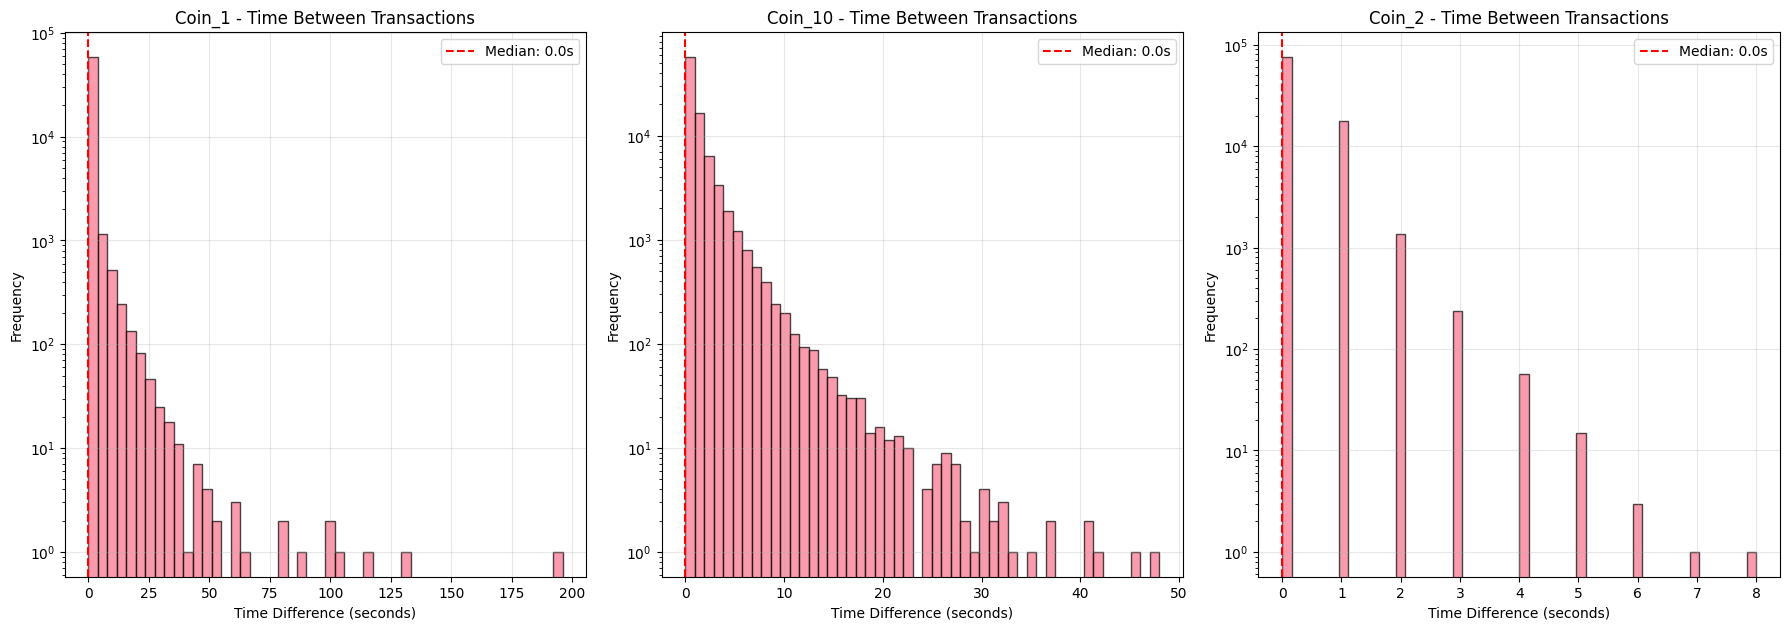


--- TEMPORAL CHARACTERISTICS SUMMARY ---
Coin       Min Gap    Median Gap   Mean Gap   Bot Activity
------------------------------------------------------------
Coin_1     0.00       0.00         0.43       94.7%       
Coin_10    0.00       0.00         0.88       82.6%       
Coin_2     0.00       0.00         0.23       98.2%       

TEMPORAL ANALYSIS COMPLETE!
Final recommended time windows: [0, 30, 60, 120, 300, 600]
In minutes: [0.0, 0.5, 1.0, 2.0, 5.0, 10.0]

These windows will be used for feature extraction in the next section.


In [3]:
def create_cross_coin_window_analysis():
    """
    Compare optimal windows across all coins to find universal patterns
    """
    
    print("\n" + "="*80)
    print("=== CROSS-COIN WINDOW ANALYSIS ===")
    print("Finding universal time windows that work across multiple coins")
    
    all_recommendations = []
    
    # Collect recommendations from all coins
    for coin_name in temporal_analyses.keys():
        temp_analysis = temporal_analyses[coin_name]
        natural_analysis = natural_scales_analyses[coin_name]
        
        # Get individual coin recommendations
        windows = recommend_optimal_windows(temp_analysis, natural_analysis)
        all_recommendations.extend(windows)
        
        print(f"\n{coin_name} recommended windows: {[round(w/60, 2) for w in windows]} minutes")
    
    # Find common patterns
    from collections import Counter
    
    # Round to nearest 30 seconds for clustering
    rounded_windows = [round(w/30)*30 for w in all_recommendations]
    window_counts = Counter(rounded_windows)
    
    print(f"\n--- WINDOW FREQUENCY ANALYSIS ---")
    print("(How often each window size is recommended across coins)")
    for window, count in sorted(window_counts.items()):
        minutes = window / 60
        print(f"{window:>6}s ({minutes:>5.1f}min): recommended by {count} coins")
    
    # Recommend universal windows
    # Windows recommended by 2+ coins
    universal_windows = sorted([w for w, count in window_counts.items() if count >= 2])
    
    # If no universal patterns, take most common ones
    if not universal_windows:
        universal_windows = sorted([w for w, count in window_counts.most_common(4)])
    
    print(f"\n--- UNIVERSAL TIME WINDOWS ---")
    print("Recommended windows that work across multiple coins:")
    for window in universal_windows:
        minutes = window / 60
        count = window_counts[window]
        print(f"  {window:>6}s ({minutes:>5.1f}min) - Used by {count} coins")
    
    # Add some standard windows for comparison
    comparison_windows = [30, 60, 120, 300, 600]  # 30s, 1min, 2min, 5min, 10min
    
    final_windows = sorted(list(set(universal_windows + comparison_windows)))
    
    print(f"\n--- FINAL RECOMMENDED WINDOW SET ---")
    print("Data-driven + standard windows for comprehensive analysis:")
    for window in final_windows:
        minutes = window / 60
        if window in universal_windows:
            print(f"  {window:>6}s ({minutes:>5.1f}min) ✓ Data-driven")
        else:
            print(f"  {window:>6}s ({minutes:>5.1f}min) ○ Standard comparison")
    
    return final_windows

def visualize_temporal_patterns():
    """
    Create visualizations of the temporal patterns discovered
    """
    
    print("\n=== TEMPORAL PATTERN VISUALIZATION ===")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    coin_names_list = list(temporal_analyses.keys())
    
    for i, coin_name in enumerate(coin_names_list[:6]):  # First 6 coins
        if i >= len(axes):
            break
            
        ax = axes[i]
        time_diffs = temporal_analyses[coin_name]['time_diffs']
        
        # Plot histogram of time differences
        ax.hist(time_diffs[time_diffs <= 300], bins=50, alpha=0.7, edgecolor='black')  # Focus on ≤5 minutes
        ax.set_title(f'{coin_name} - Time Between Transactions')
        ax.set_xlabel('Time Difference (seconds)')
        ax.set_ylabel('Frequency')
        ax.set_yscale('log')
        
        # Add median line
        median_gap = temporal_analyses[coin_name]['median_gap']
        ax.axvline(x=median_gap, color='red', linestyle='--', 
                  label=f'Median: {median_gap:.1f}s')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for i in range(len(coin_names_list), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    print(f"\n--- TEMPORAL CHARACTERISTICS SUMMARY ---")
    print(f"{'Coin':<10} {'Min Gap':<10} {'Median Gap':<12} {'Mean Gap':<10} {'Bot Activity':<12}")
    print("-" * 60)
    
    for coin_name in coin_names_list:
        temp_data = temporal_analyses[coin_name]
        min_gap = temp_data['min_gap']
        median_gap = temp_data['median_gap']
        mean_gap = temp_data['mean_gap']
        bot_activity = temp_data['frequency_patterns']['very_fast']
        
        print(f"{coin_name:<10} {min_gap:<10.2f} {median_gap:<12.2f} {mean_gap:<10.2f} {bot_activity:<12.1%}")

# Run the cross-coin analysis
if temporal_analyses:  # Only run if we have data
    final_recommended_windows = create_cross_coin_window_analysis()
    visualize_temporal_patterns()
    
    print(f"\n" + "="*80)
    print("TEMPORAL ANALYSIS COMPLETE!")
    print(f"Final recommended time windows: {final_recommended_windows}")
    print(f"In minutes: {[round(w/60, 2) for w in final_recommended_windows]}")
    print("\nThese windows will be used for feature extraction in the next section.")
else:
    print("No temporal analysis data available. Using default windows: [30, 60, 300, 600] seconds")
    final_recommended_windows = [30, 60, 300, 600]  # 30s, 1min, 5min, 10min


# Data-Driven Feature Extraction & Signal Development

**Based on Temporal Analysis Results**:
- **Optimal Windows**: [30s, 1min, 2min, 5min, 10min]
- **Approach**: Extract 100+ features across these data-driven windows
- **Goal**: Build predictive signals for 5-15 minute profit opportunities

**Key Advantage**: Using actual data characteristics instead of arbitrary time windows
